In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt



In [2]:
# 1. Rotated MNIST Dataset Preparation
class RotatedMNIST(Dataset):
    def __init__(self, mnist_dataset, angle):
        self.mnist_dataset = mnist_dataset
        self.angle = angle
        self.transform = transforms.Compose([
            transforms.RandomRotation([angle, angle]),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        img, label = self.mnist_dataset[idx]
        img = self.transform(img)
        return img.view(-1), label

# Create Environments
train_env1 = RotatedMNIST(datasets.MNIST(root='./data', train=True, download=True), angle=0)
train_env2 = RotatedMNIST(datasets.MNIST(root='./data', train=True, download=True), angle=30)
test_env = RotatedMNIST(datasets.MNIST(root='./data', train=False, download=True), angle=45)

# Dataloaders
batch_size = 64
train_loader_env1 = DataLoader(train_env1, batch_size=batch_size, shuffle=True)
train_loader_env2 = DataLoader(train_env2, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_env, batch_size=batch_size, shuffle=False)



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 56802308.46it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1571945.52it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 14097636.01it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3459329.72it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
# 2. MLP Model Definition
class SimpleMLP(nn.Module):
    def __init__(self, input_size=784, hidden_size=128, num_classes=10):
        super(SimpleMLP, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        features = self.feature_extractor(x)
        logits = self.classifier(features)
        return logits, features

# 3. Loss Functions
def irm_penalty(logits, labels):
    scale = torch.ones((logits.shape[1],), requires_grad=True, device=logits.device)
    loss = torch.mean((logits * scale).sum(dim=1) - labels)**2
    return loss

def compute_variance(features):
    mean = torch.mean(features, dim=0)
    var = torch.mean(torch.sum((features - mean)**2, dim=1))
    return var

# 4. Training Loop
def train(model, optimizer, envs, method='IRM Basic', lambda_val=1.0, gamma=1.0, w=[1, 1, 1]):
    model.train()
    losses = []
    for env_loader in envs:
        for data, target in env_loader:
            data, target = data.to(device), target.to(device)
            logits, features = model(data)
            
            # Cross-Entropy Loss
            loss_erm = nn.CrossEntropyLoss()(logits, target)
            
            # IRM Penalty
            penalty = irm_penalty(logits, target)
            
            # Variance Regularization
            var_reg = compute_variance(features)
            
            # Combine Losses
            if method == 'IRM Basic':
                loss = loss_erm + lambda_val * penalty
            elif method == 'IB-IRM':
                loss = loss_erm + lambda_val * penalty + gamma * var_reg
            elif method == 'PAIR':
                loss = w[0] * loss_erm + w[1] * penalty + w[2] * var_reg
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
    return np.mean(losses)

# 5. Testing Loop
def test(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            logits, _ = model(data)
            pred = logits.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    return correct / total



In [15]:
methods = ['IRM Basic', 'IB-IRM', 'PAIR']
results = {method: {'iid': [], 'ood': []} for method in methods}
for method in methods:
    print(f"Training with {method}")
    
    # Reinitialize the model for each method
    model = SimpleMLP().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Add learning rate scheduler

    # Adjust weights for PAIR
    if method == 'PAIR':
        w = [0.5, 1.0, 0.1]  # Adjust weights for ERM, IRM, and Variance

    for epoch in range(1, num_epochs + 1):
        train_loss = train(
            model, optimizer, [train_loader_env1, train_loader_env2],
            method=method, lambda_val=1.0, gamma=0.1, w=w if method == 'PAIR' else [1, 1, 1]
        )
        iid_acc = test(model, train_loader_env1)
        ood_acc = test(model, test_loader)
        results[method]['iid'].append(iid_acc)
        results[method]['ood'].append(ood_acc)
        print(f"Epoch {epoch} | IID Acc: {iid_acc:.4f}, OOD Acc: {ood_acc:.4f}")
        scheduler.step()  # Adjust learning rate


Training with IRM Basic
Epoch 1 | IID Acc: 0.6964, OOD Acc: 0.8145
Epoch 2 | IID Acc: 0.8074, OOD Acc: 0.8387
Epoch 3 | IID Acc: 0.8396, OOD Acc: 0.8666
Epoch 4 | IID Acc: 0.8452, OOD Acc: 0.8770
Epoch 5 | IID Acc: 0.8889, OOD Acc: 0.8856
Epoch 6 | IID Acc: 0.9044, OOD Acc: 0.8834
Epoch 7 | IID Acc: 0.9204, OOD Acc: 0.8904
Epoch 8 | IID Acc: 0.9285, OOD Acc: 0.8819
Epoch 9 | IID Acc: 0.9358, OOD Acc: 0.8795
Epoch 10 | IID Acc: 0.9357, OOD Acc: 0.8958
Training with IB-IRM
Epoch 1 | IID Acc: 0.5992, OOD Acc: 0.7907
Epoch 2 | IID Acc: 0.7414, OOD Acc: 0.8422
Epoch 3 | IID Acc: 0.7837, OOD Acc: 0.8539
Epoch 4 | IID Acc: 0.8556, OOD Acc: 0.8557
Epoch 5 | IID Acc: 0.8680, OOD Acc: 0.8637
Epoch 6 | IID Acc: 0.9021, OOD Acc: 0.8563
Epoch 7 | IID Acc: 0.8882, OOD Acc: 0.8678
Epoch 8 | IID Acc: 0.9006, OOD Acc: 0.8784
Epoch 9 | IID Acc: 0.8992, OOD Acc: 0.8832
Epoch 10 | IID Acc: 0.9015, OOD Acc: 0.8805
Training with PAIR
Epoch 1 | IID Acc: 0.3510, OOD Acc: 0.5080
Epoch 2 | IID Acc: 0.6117, OOD 

In [16]:
print(results)

{'IRM Basic': {'iid': [0.6963666666666667, 0.8074, 0.8396166666666667, 0.8452333333333333, 0.8888666666666667, 0.9044333333333333, 0.9203833333333333, 0.9285, 0.93585, 0.9357166666666666], 'ood': [0.8145, 0.8387, 0.8666, 0.877, 0.8856, 0.8834, 0.8904, 0.8819, 0.8795, 0.8958]}, 'IB-IRM': {'iid': [0.5992333333333333, 0.7413666666666666, 0.7836666666666666, 0.8555833333333334, 0.86805, 0.9020833333333333, 0.8881833333333333, 0.9005666666666666, 0.8991666666666667, 0.9014833333333333], 'ood': [0.7907, 0.8422, 0.8539, 0.8557, 0.8637, 0.8563, 0.8678, 0.8784, 0.8832, 0.8805]}, 'PAIR': {'iid': [0.35096666666666665, 0.6117166666666667, 0.7084166666666667, 0.70015, 0.7404166666666666, 0.8393, 0.86565, 0.86295, 0.8802, 0.8888166666666667], 'ood': [0.508, 0.7197, 0.8019, 0.8095, 0.7736, 0.8164, 0.8022, 0.8134, 0.7937, 0.8077]}}


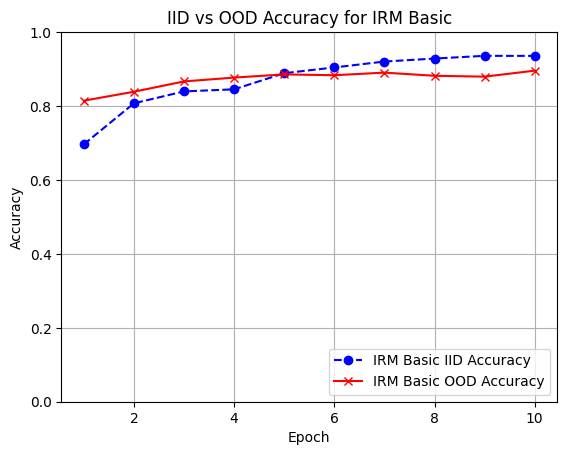

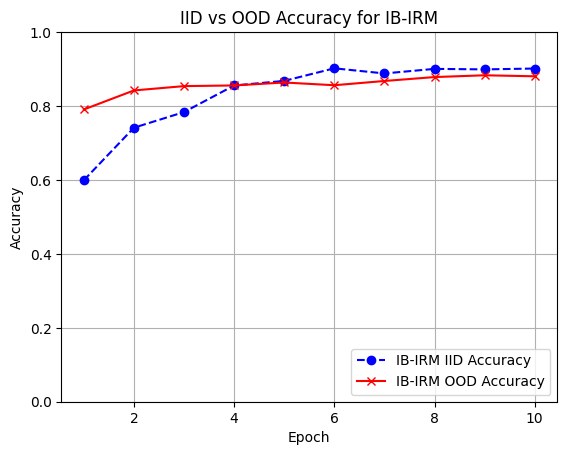

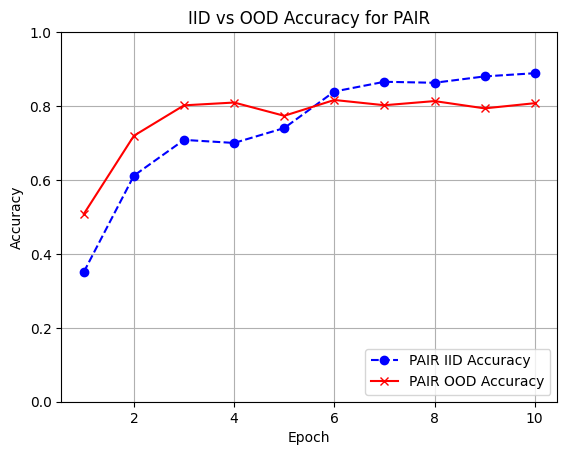

In [17]:
import matplotlib.pyplot as plt

# Plot IID and OOD Accuracy Trends for Each Method
for method in methods:
    plt.figure()  # Create a new figure for each method
    epochs = list(range(1, num_epochs + 1))  # Epoch numbers (1 to num_epochs)
    
    # Plot IID Accuracy
    plt.plot(epochs, results[method]['iid'], label=f'{method} IID Accuracy', linestyle='--', marker='o', color='blue')
    
    # Plot OOD Accuracy
    plt.plot(epochs, results[method]['ood'], label=f'{method} OOD Accuracy', linestyle='-', marker='x', color='red')
    
    # Add Title and Labels
    plt.title(f'IID vs OOD Accuracy for {method}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
    plt.grid(True)  # Add a grid for better visualization
    
    # Add Legend
    plt.legend(loc='lower right')
    
    # Show Plot
    plt.show()


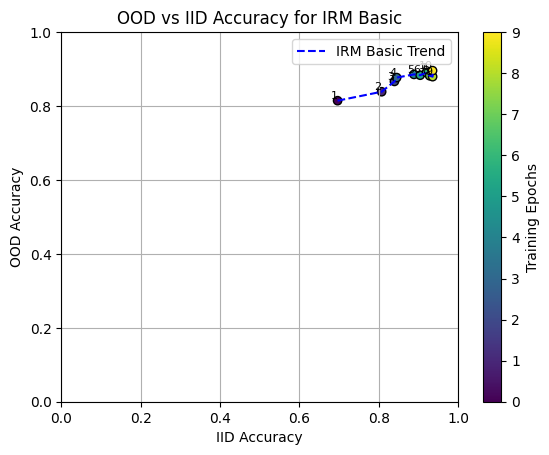

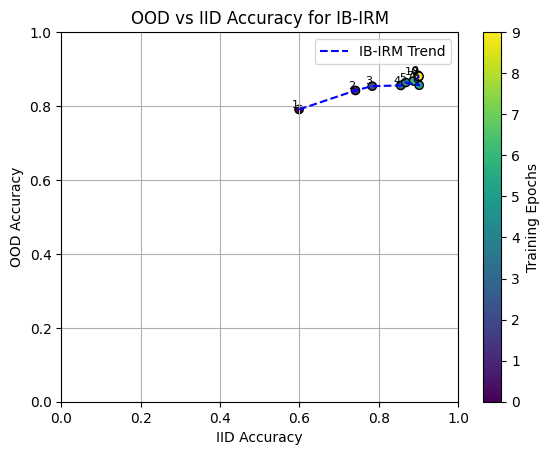

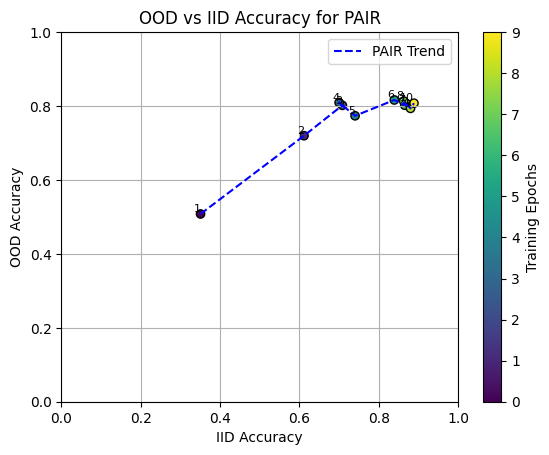

In [18]:
import matplotlib.pyplot as plt

# Plot OOD Accuracy vs. IID Accuracy for Each Method
for method in results.keys():
    plt.figure()  # Create a new figure for each method
    
    iid_acc = results[method]['iid']  # IID Accuracy
    ood_acc = results[method]['ood']  # OOD Accuracy
    
    # Scatter plot of OOD accuracy vs. IID accuracy
    plt.scatter(iid_acc, ood_acc, c=range(len(iid_acc)), cmap='viridis', edgecolor='black')
    plt.plot(iid_acc, ood_acc, linestyle='--', label=f'{method} Trend', color='blue')
    
    # Add epoch labels to each point
    for epoch, (x, y) in enumerate(zip(iid_acc, ood_acc), start=1):
        plt.text(x, y, str(epoch), fontsize=8, ha='right', va='bottom')
    
    # Add Titles, Labels, and Legend
    plt.title(f'OOD vs IID Accuracy for {method}')
    plt.xlabel('IID Accuracy')
    plt.ylabel('OOD Accuracy')
    plt.ylim(0, 1)  # Accuracy range
    plt.xlim(0, 1)  # Accuracy range
    plt.grid(True)
    plt.colorbar(label='Training Epochs')  # Color bar for epochs
    plt.legend()
    
    # Show the plot
    plt.show()
